In [46]:
%matplotlib inline

from pymongo import MongoClient
import math
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [47]:
def divtd(td1, td2):
    us1 = td1.microseconds + 1000000 * (td1.seconds + 86400 * td1.days)
    us2 = td2.microseconds + 1000000 * (td2.seconds + 86400 * td2.days)
    return float(us1) / us2

def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

try:
    import config
    print('using local config file')
    mongodb_uri = config.mongodb_uri
except:
    print('using environment variable')
    mongodb_uri = os.getenv('MONGODB_URI')

using local config file


In [48]:
print("Analyzing Data")
success = True

if success:
    try:
        client = MongoClient(mongodb_uri)
        db = client.get_database()
    except Exception as e:
        print('mongo login error ', str(e))
        success = False
if success:
    try:
        dataCursor = db.percentageMove.find(projection={'_id': False},sort=[("timestamp", 1)])
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False
        
if success:
    try:
        df =  pd.DataFrame(list(dataCursor)).set_index(['timestamp'])
        filteredDf = df[~is_outlier(df)]
        increase = df+1
        cumulative = increase.cumprod(axis=0)
        cumulative = cumulative - cumulative.iloc[0]
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False  
        
if success:
    try:
        dataCursor = db.tracking.find(projection={'_id': False},sort=[("timestamp", 1)])
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False
        
if success:
    try:
        tracking =  pd.DataFrame(list(dataCursor)).set_index(['timestamp'])
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False  
        
if success:
    try:
        dataCursor = db.rawPrices.find(projection={'_id': False},sort=[("timestamp", 1)])
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False
        
if success:
    try:
        raw =  pd.DataFrame(list(dataCursor)).set_index(['timestamp'])
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False                


Analyzing Data


/Users/stephan/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


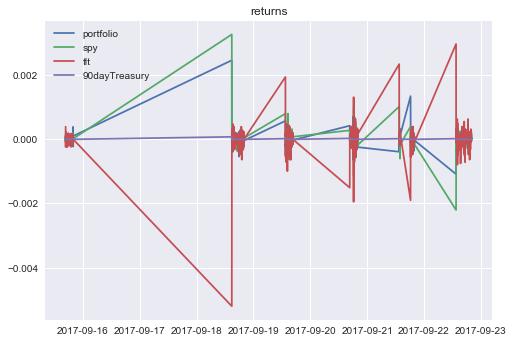

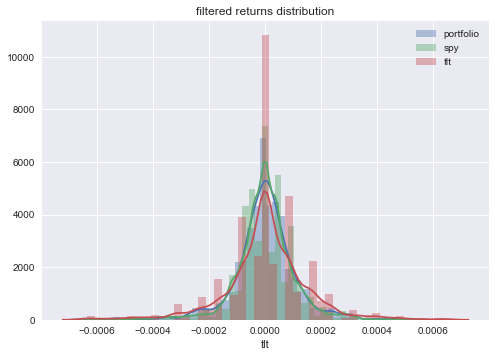

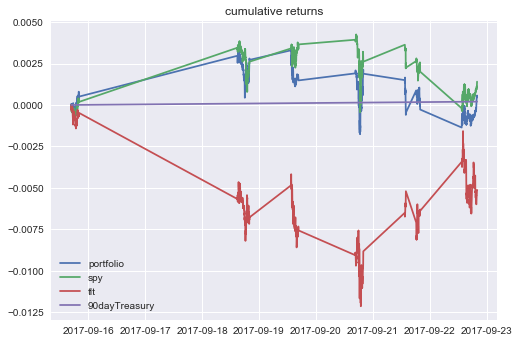

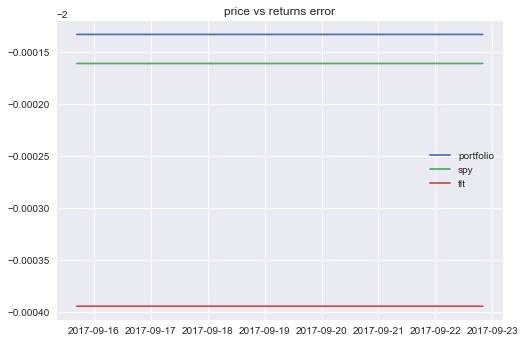

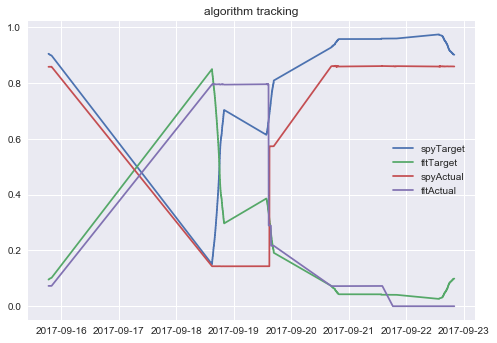

In [49]:
if success:
    plt.figure()
    plt.title('returns')
    plt.plot(df['portfolio'])
    plt.plot(df['spy'])
    plt.plot(df['tlt'])
    plt.plot(df['90dayTreasury'])
    plt.legend()
    
    plt.figure()
    plt.title('filtered returns distribution')
    sns.distplot(filteredDf['portfolio'],label="portfolio")
    sns.distplot(filteredDf['spy'],label="spy")
    sns.distplot(filteredDf['tlt'],label="tlt")
    plt.legend()
    
    plt.figure()
    plt.title('cumulative returns')
    plt.plot(cumulative['portfolio'])
    plt.plot(cumulative['spy'])
    plt.plot(cumulative['tlt'])
    plt.plot(cumulative['90dayTreasury'])
    plt.legend()
    
    plt.figure()
    plt.title('price vs returns error')
    plt.plot(cumulative['portfolio']-(raw['portfolio']/raw['portfolio'].iloc[0])-1)
    plt.plot(cumulative['spy']-(raw['spy']/raw['spy'].iloc[0])-1)
    plt.plot(cumulative['tlt']-(raw['tlt']/raw['tlt'].iloc[0])-1)
    plt.legend()
    
    plt.figure()
    plt.title('algorithm tracking')
    plt.plot(tracking['spyTarget'])
    plt.plot(tracking['tltTarget'])
    plt.plot(tracking['spyActual'])
    plt.plot(tracking['tltActual'])
    plt.legend()

In [50]:
if success:
    print('original data \n')
    print(df.describe())
    print('\n filtered data \n')
    print(filteredDf.describe())
    
    
    df['elapsed'] = df.index-df.index[0]
    year = datetime.timedelta(days=365)
    yearPeriods = divtd(year,(df['elapsed'])[-1])
    
    df['spyExcess'] = df['spy']-df['90dayTreasury']
    df['tltExcess'] = df['tlt']-df['90dayTreasury']
    df['portfolioExcess'] = df['portfolio']-df['90dayTreasury']
    df['spyInfoExcess'] = df['portfolio']-df['spy']
    df['tltInfoExcess'] = df['portfolio']-df['tlt']
    
    
    meanSpyExcess = df['spyExcess'].mean()
    meanTltExcess = df['tltExcess'].mean()
    meanPortfolioExcess = df['portfolioExcess'].mean()
    meanSpyInfoExcess = df['spyInfoExcess'].mean()
    meanTltInfoExcess = df['tltInfoExcess'].mean()
    
    stdSpyExcess = df['spyExcess'].std()
    stdTltExcess = df['tltExcess'].std()
    stdPortfolioExcess = df['portfolioExcess'].std()
    stdSpyInfoExcess = df['spyInfoExcess'].std()
    stdTltInfoExcess = df['tltInfoExcess'].std()
    
    rawSpySharpe = meanSpyExcess/stdSpyExcess
    spySharpe = math.sqrt(yearPeriods)*rawSpySharpe
    print('\nrawSpySharpe = ',rawSpySharpe)
    print('spySharpe = ',spySharpe)
    
    rawTltSharpe = meanTltExcess/stdTltExcess
    tltSharpe = math.sqrt(yearPeriods)*rawTltSharpe
    print('\nrawTltSharpe = ',rawTltSharpe)
    print('tltSharpe = ',tltSharpe)
    
    rawPortfolioSharpe = meanPortfolioExcess/stdPortfolioExcess
    portfolioSharpe = math.sqrt(yearPeriods)*rawPortfolioSharpe
    print('\nrawPortfolioSharpe = ',rawPortfolioSharpe)
    print('portfolioSharpe = ',portfolioSharpe)
    
    rawSpyInfo = meanSpyInfoExcess/stdSpyInfoExcess
    spyInfo = math.sqrt(yearPeriods)*rawSpyInfo
    print('\nrawSpyInfo = ',rawSpyInfo)
    print('spyInfo = ',spyInfo)
    
    rawTltInfo = meanTltInfoExcess/stdTltInfoExcess
    tltInfo = math.sqrt(yearPeriods)*rawTltInfo
    print('\nrawTltInfo = ',rawTltInfo)
    print('tltInfo = ',tltInfo)

original data 

       90dayTreasury     portfolio          spy          tlt
count   1.390000e+03  1.390000e+03  1390.000000  1390.000000
mean    1.440586e-07  5.145413e-07     0.000001    -0.000003
std     2.424740e-06  1.459833e-04     0.000165     0.000261
min     3.939833e-10 -1.085608e-03    -0.002204    -0.005203
25%     1.930589e-08 -5.171232e-05    -0.000040    -0.000079
50%     1.945339e-08  0.000000e+00     0.000000     0.000000
75%     1.958519e-08  5.172726e-05     0.000040     0.000079
max     7.825648e-05  2.465111e-03     0.003271     0.002974

 filtered data 

       90dayTreasury    portfolio           spy          tlt
count   1.362000e+03  1362.000000  1.362000e+03  1362.000000
mean    1.983224e-08    -0.000002 -7.688507e-07     0.000004
std     5.412005e-09     0.000113  1.073241e-04     0.000148
min     3.939833e-10    -0.000641 -6.414368e-04    -0.000635
25%     1.930491e-08    -0.000052 -4.013405e-05    -0.000079
50%     1.945204e-08     0.000000  0.000000e+00    